# **Deep Beach State** (V2)
**An application of a convolutional neural network on the classification of beach states using video imagery.**

---

### Author: Stan Oerlemans
This notebook contains the script used for my master's thesis: *Image
based beach state classification using convolutional
neural networks.*

---

## UPDATES:

This work is an extension on the previous work on beach state classification: https://github.com/anellenson/DeepBeachState.

# Introduction

Subtidal sandbars are ubiquitous features in the nearshore zone of many sandy coasts, and unravelling their dynamics is crucial to the understanding of nearshore sediment pathways. Wave breaking and wave-driven currents constantly rearrange nearshore sediment into complex patterns leading to the development of sandbar morphology, ranging from shore-parallel ridges of sand to an alongshore alternation of shore-attached bars and rip-channels. Wright and Short (1984) created a widely used beach state classification scheme, in which they distinguish a total of six beach states with distinct sandbar configurations.


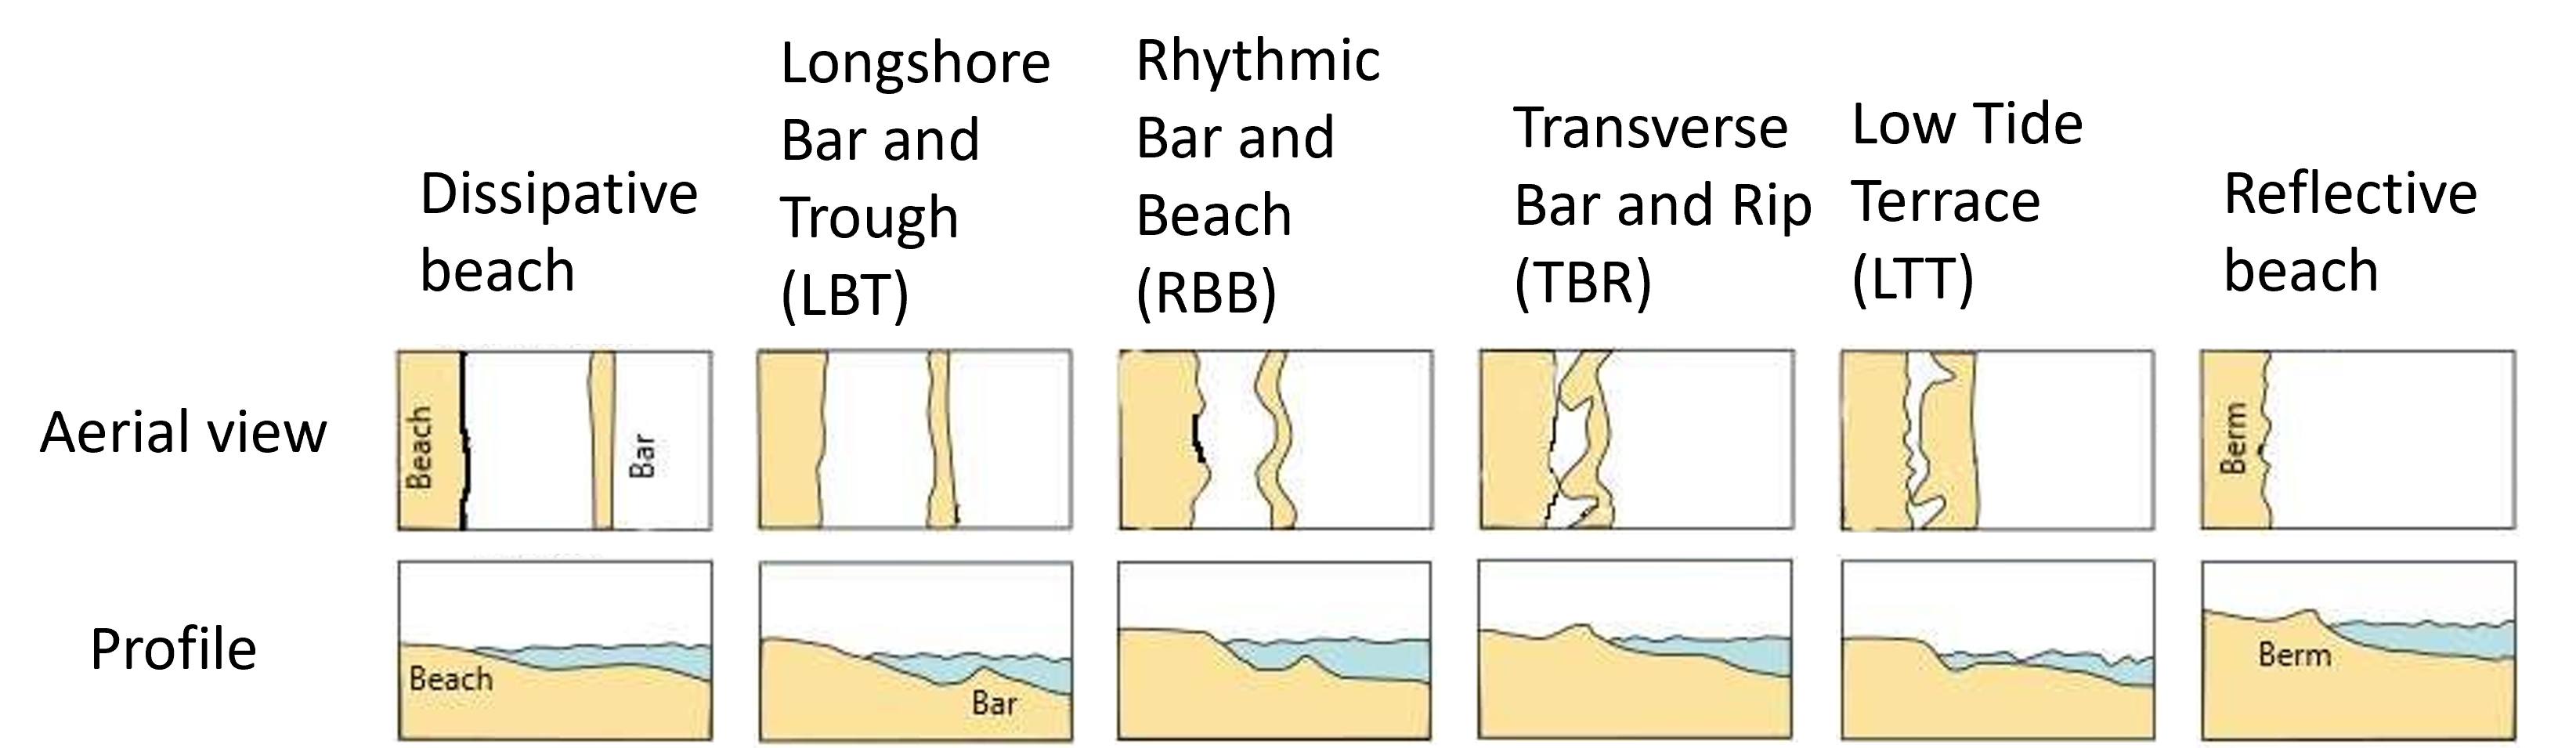

The tremendous progress in data-driven learning in image recognition over the past years has led to a first automated classification of single-barred beach states from video (Argus) imagery (Ellenson et al., 2020), using a convolutional neural network (CNN). We build upon this work to extend the classification of single-barred beach states to double-barred beaches. The objective of this study is to perform a multi-class classification of beach states for the inner and outer bar separately.

To create our CNN model we usedthe pretrained network ResNet50 in combination with transfer learning to fine-tune the for our classification task. However, some other architectures are already pre-coded and ready to use. 

Our data consisted of labelled images from the single-barred beaches Narrabeen (Australia) and Duck (US), as used by Ellenson et al. (2020), complemented with images of the double-barred beach of the Gold Coast (Australia). 

#1. Dataset Collection and Visualization
Now lets start by mounting our drive and loading the train/validation/test dataframes.
I sorted and distributed the data from each location separately from the other locations. When you want to use the data of a single location, you only need to run the code corresponding to that location. When you want to use the data of multiple locations you run the cells corresponding to these locations followed by the codes to merge the datasets.

In [1]:
# When running from colab upload your data to your google drive and mount the drive first
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Datenum to Datetime**

The Argus images were named with the matlab datenum code. Therefore, I needed to convert this first to datetime to be able to sort them by time.

In [2]:
from datetime import date, timedelta
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return date.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

## Load Data
The datasets consist out of a folder with all images and an .csv file containing the image id's + the corresponding label. Therefore, we use a function to read this information correctly and to create our custom datasets.

In [3]:
import pandas as pd
data_dir = '/content/drive/My Drive/DBS/Duck_publication'                                     # Path to the folder containing all data of Duck.
df_main = pd.read_csv(data_dir + "/labels.csv", header=None) # Reading the .csv file containing the image id's and labels.
img_dir = data_dir + '/images/' 
# Below are the folders used to save certain files.
model_path = data_dir + '/models'  
figures = data_dir + '/figures/'                                                
cam_dir = data_dir + '/CAM'

In [4]:
# Creating headers for each column.
df_main.columns = ['img_id', 'label']    
# Show content of csv file.
df_main.head()

,img_id,label
0,775152000.Mon.Jul.25_16_00_00.GMT.1994.argus02...,0
1,779731200.Fri.Sep.16_16_00_00.GMT.1994.argus02...,0
2,764182800.Sun.Mar.20_17_00_00.GMT.1994.argus02...,1
3,896889600.Wed.Jun.03_16_00_00.GMT.1998.argus02...,2
4,960566400.Fri.Jun.09_16_00_00.GMT.2000.argus02...,1


In [5]:
#label of classes
class_names = ['Ref', 'LTT', 'TBR', 'RBB', 'LBT']
# Apply only when data analysing - not for training.

idx_to_class = { i : class_names[i] for i in range(0, len(class_names) ) }
df_main.label=[idx_to_class[item] for item in df_main.label]
classes = df_main.label.unique()
num_classes = len(classes)
print('class names:', classes)

# encoder and decoder to convert classes into integers or strings
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

class names: ['Ref' 'LTT' 'TBR' 'RBB' 'LBT']


In [6]:
import re
x = df_main['img_id']
y = df_main['label']

dates =[]
years = []
months = []
for img_id in df_main['img_id']:
  year = int(img_id.split('.')[5])
  month = str(img_id.split('.')[2])
  years.append(year)
  months.append(month)
  unixEpoch = date.toordinal(date(1971,1,2))
  splitted =  re.findall(r'[0-9]+', img_id)
  argusepoch = int(splitted[0])
  offset = argusepoch / (24*3600)
  dnum = unixEpoch + offset
  datum = datenum_to_datetime(dnum)
  dates.append(datum)

df_main['Year'] = years
df_main['Month'] = months
df_main['Date'] = dates
df_main.head()

,img_id,label,Year,Month,Date
0,775152000.Mon.Jul.25_16_00_00.GMT.1994.argus02...,Ref,1994,Jul,1994-07-25
1,779731200.Fri.Sep.16_16_00_00.GMT.1994.argus02...,Ref,1994,Sep,1994-09-16
2,764182800.Sun.Mar.20_17_00_00.GMT.1994.argus02...,LTT,1994,Mar,1994-03-20
3,896889600.Wed.Jun.03_16_00_00.GMT.1998.argus02...,TBR,1998,Jun,1998-06-03
4,960566400.Fri.Jun.09_16_00_00.GMT.2000.argus02...,LTT,2000,Jun,2000-06-09


### Visualize Data
Important is to know with what kind of data we are dealing. Therefore we visualise raw images.

CPU times: user 301 ms, sys: 25.1 ms, total: 327 ms
Wall time: 383 ms


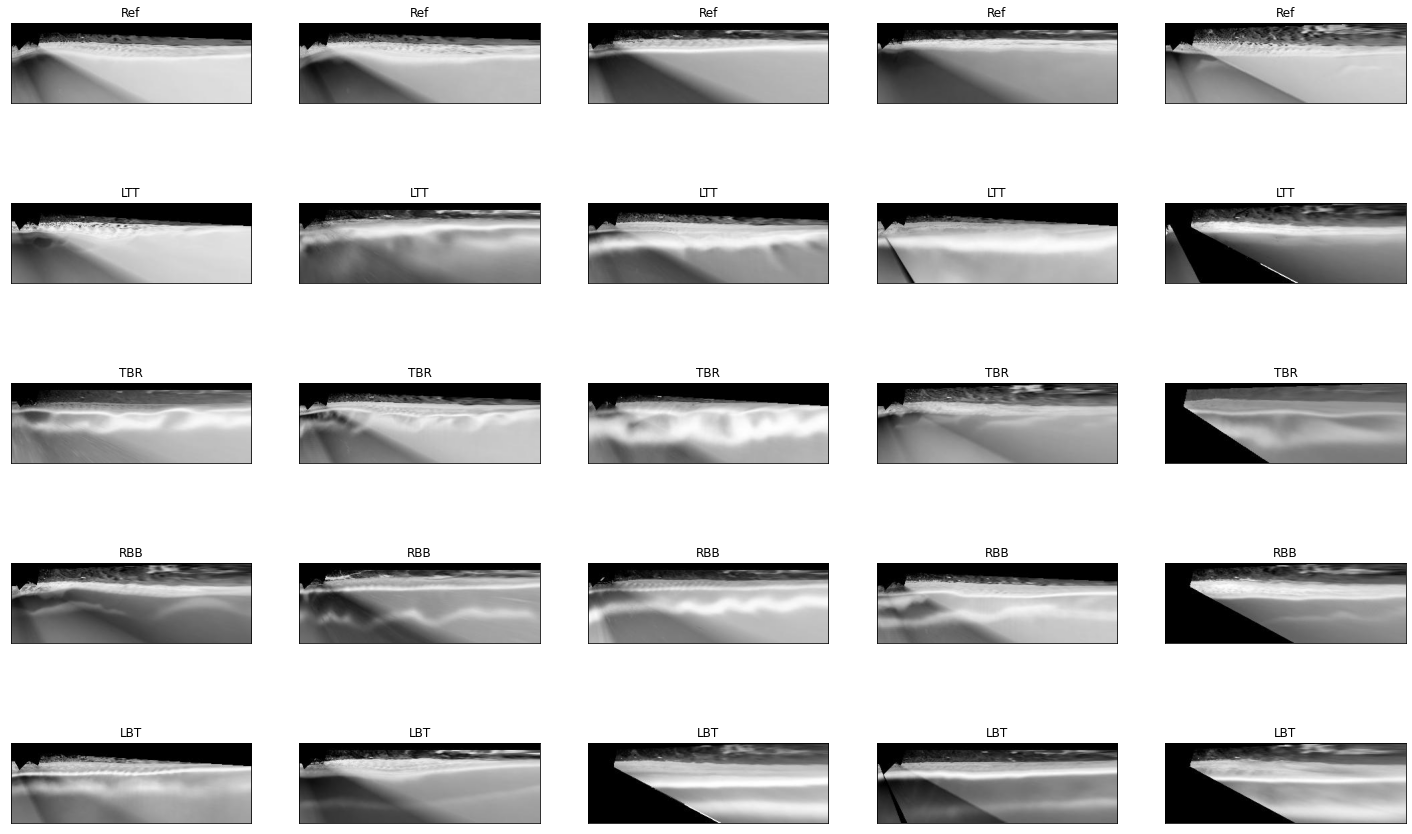

In [7]:
%%time
import cv2
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(df_main.label.unique()):
    for i, (idx, row) in enumerate(df_main.loc[df_main.label == class_id].sample(5).iterrows()):
      class_id = decoder[class_id]
      ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
      path=f"{img_dir}/{row['img_id']}"
      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (361, 121))
      class_id = encoder[class_id]
      plt.imshow(image)
      ax.set_title((class_id) )

### Visualize Distribution
Creating plots for the visualisation and distribution of the different classes over time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa70490a90>,
      dtype=object)

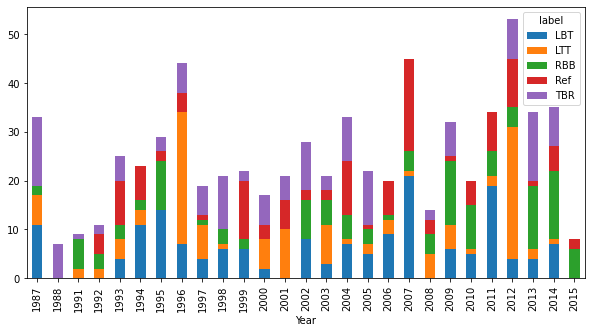

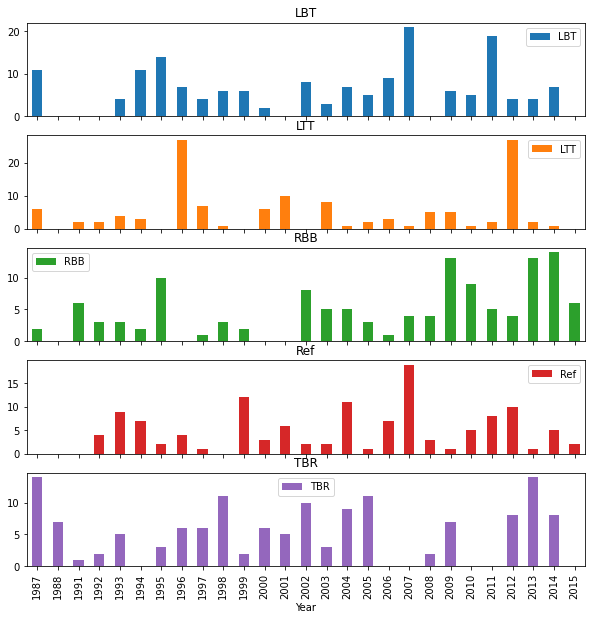

In [8]:
df_main.groupby('Year')['label'].value_counts()
df_gb = df_main.groupby(['Year','label']).size().unstack(level=1)
df_gb.plot.bar(figsize=(10,5),stacked=True)
df_gb.plot.bar(figsize=(10,10),subplots = True)                                                     

#2. Initialize the Network

The second step is to initialize the network for the task at hand. Many different architectures are available of which some are already included in this algorithm. In addition, for different tasks, different parameters may be used to optimize performance. 

### Inputs
Here we set all parameters needed before training the code.

- **model_name**: input the name of the model you wish to use and can be selected from:
    - resnet50
    - alexnet
    - vgg
    - squeezenet
    - densenet
    - inception

The other inputs are as follows: 
- **batch_size** is the batch size used for training and may be adjusted according to the capability of your machine.
- **num_epochs** is the maximum number of epochs to run.    
- **feature_extract = False**; the model is fine-tuned and all model parameters are updated. 
- **feature_extract = True**; only the last layer parameters are updated, the other remain frozen.

In [9]:
# Models to choose from [resnet50, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'resnet50'

# Batch size for training (change depending on how much memory you have).
batch_size = 32
# The more workers, the better.
num_workers = 2

# Number of epochs to train for 
num_epochs = 1000               # I put num_epochs very high because an early stopping mechanism was implemented (discussed later on).
patience = 20                   # The patience for the early stopping, meaning the amount of times in a sequential order the code does not improve.     
learning_rate = 0.002           # Initial learning rate.

# Flag for feature extracting. When False, we fine-tune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

**Set Model Paramater's .requires_grad attribute**

This function sets the 'requires_grad' attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have 'requires_grad = True', which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Reshape the Network
Now the most interesting part. Here is where we handle the reshaping of each network. Note, this is not an automatic procedure and is unique for each model. Recall, the final layer of a CNN model, which is often an FC layer, has the same number of nodes as the number of output classes in the dataset. Since all of the models have been pretrained on ImageNet, they all have output layers of size 1000, one node for each class. The goal here is to reshape the last layer to have the same number of inputs as before, AND to have the same number of outputs as the number of classes in the dataset. In the following sections we will discuss how to alter the architecture of each model individually. But first, there is one important detail regarding the difference between finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .requires_grad attribute to False. This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have .requires_grad=True so only the new layer's parameters will be updated. When we are finetuning we can leave all of the .required_grad's set to the default of True.

In [11]:
from torchvision import models
from torch import nn, optim
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "VGG":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [12]:
# Show the whole model
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Early stopping
Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops.

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Optimizer
Now that the model structure is correct, the final step for finetuning and feature extracting is to create an optimizer that only updates the desired parameters. Recall that after loading the pretrained model, but before reshaping, if feature_extract=True we manually set all of the parameter's .requieres_grad attributes to False. Then reinitialized layer's parameters have .requires_grad=True by default. So now we knowl that all parameters that have .requires_grad=True should be optimized. Next, we make a list of such parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When finetuning, this list should be long and include all of the model parameters. However, when feature extracting this list should be short and only include the weights and biases of the reshaped layers.

In this part the parameters to be optimized/updated are gathered. If we are finetuning we will be updating all paramters and the output will be a long list. However, if we are doing feature extract method, we will only update the parameters that we have juist initialized, i.e. the parameters with requires_grad is True, and the output list will be short.

In [14]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate)

#test
#optimizer_ft = optim.Adam(params_to_update, lr=0.0003)

cuda:0
Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1

#3. Data preparation

Before training the model, we need to prepare our data. We distribute the data into a train, validition and test set. 

For optimization we applied:

- Weights
- Normalisation
- Resizing
- Augmentations

## Train, Validation and Test Sets


**Train Set**

Sort the dataset by date and create a train dataset with the first 80% of the data. To change the percentage of images edit the "*train_size=0.8*".

(544,) (544,) (136,) (136,)


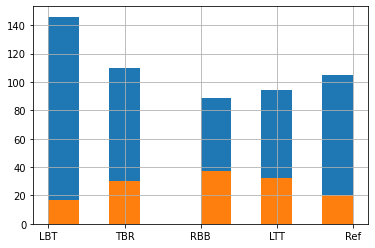

In [15]:
from sklearn.model_selection import train_test_split
x = df_main.sort_values(by='Date')['img_id']
y = df_main.sort_values(by='Date')['label']
train_x, rest_x, train_y, rest_y = train_test_split(x, y, train_size=0.8, shuffle=False, stratify=None)
                                                      
print(train_x.shape, train_y.shape, rest_x.shape, rest_y.shape)

# Print histogram with the distribution of training images compared to the remaining images.
train_y.hist()
rest_y.hist()

df_train = {'img_id':train_x,'label':train_y}
df_rest = {'img_id':rest_x,'label':rest_y}  

# Create the pandas DataFrame
ds_train = pd.DataFrame(df_train)
ds_rest = pd.DataFrame(df_rest) 

In [16]:
# Print the training images with corresponding classes to an .xlsx file.
dftr = ds_train
dftr.to_excel(data_dir + '/dataset_train.xlsx', index = True)

**Validation and Test Sets**

The remaining images are distributed into a validation and test set, both consisting of 50% of the remaining data. As we want all classes to be represented in both sets we used a stratified split.

To change the 50% distribution change "*test_size=0.5*".

(68,) (68,) (68,) (68,)


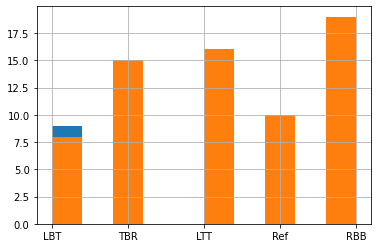

In [17]:
from sklearn.model_selection import train_test_split
x = ds_rest['img_id']
y = ds_rest['label']
test_x, val_x, test_y, val_y = train_test_split(x, y, test_size=0.5, shuffle=True, stratify=y)
                                                      
print(test_x.shape, test_y.shape, val_x.shape, val_y.shape)

# Print histogram with the distribution of validation and test images.
test_y.hist()
val_y.hist()

df_val = {'img_id':val_x,'label':val_y}
df_test = {'img_id':test_x,'label':test_y}  

# Create the pandas DataFrame and change the classes back to integers.
ds_val = pd.DataFrame(df_val)
ds_val.label=[decoder[item] for item in ds_val.label] 
ds_test = pd.DataFrame(df_test)
ds_test.label=[decoder[item] for item in ds_test.label] 

**Custom_DS**

Before we can start training we have to create datasets from our dataframes containing the distributed images. We use a function to read this information correctly and to create our custom datasets.

In [18]:
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
class ImageDataset(Dataset):

  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    
    self.image_names=self.csv[:]['img_id']
    self.labels=np.array(self.csv[:]['label'])
  
  def __len__(self):
    return len(self.image_names)

  def __getitem__(self,index):
    ID = self.image_names.iloc[index]

    image=cv2.imread(self.img_folder+self.image_names.iloc[index])
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    image=self.transform(image)
    targets=self.labels[index]

    return image, targets, ID

#### Weights

Sorting the data before splitting may result in highly unbalanced datasets. An unbalanced training dataset might adversely affect the training process leadiung to a bias during predicition of the model. To counter this problem and balance out the bias we over-sampled the data on the classes' occurrence ratio. This ratio is calculated by *1/(training images in specific class)*.

In [19]:
import torch
class_count = ds_train.value_counts('label')
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
#class_weights = torch.tensor([..., ..., ..., ..., ...])                          # For manually applying weights.
print(class_count)
print(class_weights)

# For visualization of the classes we change the training labels 
# to integers after training.
ds_train.label=[decoder[item] for item in ds_train.label]                         # Converting labels to integers for weighting.
target_list = list(ds_train.label)
class_weights_all = class_weights[target_list]

label
LBT    146
TBR    110
Ref    105
LTT     94
RBB     89
dtype: int64
tensor([0.0068, 0.0091, 0.0095, 0.0106, 0.0112])


In [20]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

#### Normalization

Not all images may contain pixels in the same value range. Especially in the case when applying feature extraction of fine-tuning. Hence, we normalize the images to range [*0,1*].

In [21]:
import numpy as np
from tqdm.autonotebook import tqdm
from torchvision import datasets, transforms
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((input_size,input_size)),
                                        transforms.ToTensor()])

train_dataset = ImageDataset(ds_train,img_dir,train_transforms)
train_dataloader =  DataLoader(train_dataset, batch_size = batch_size , shuffle = True)
mean,std = normalization_parameter(train_dataloader)
print(mean)
print(std)

  0%|          | 0/17 [00:00<?, ?it/s]

[0.44531336 0.44531336 0.44531336]
[0.2905898 0.2905898 0.2905898]


#### Augmentations
Apply geometric transformations to increase the amount of data. The geometric  transformations are mostly applied to the training images as we need large numbers of training images and not testing or validation images.

In [22]:
# Data augmentation 
# Just normalization for validation and testing
train_transform  = transforms.Compose([transforms.ToPILImage(),
#                                       transforms.RandomHorizontalFlip(p = 1),
                                       transforms.RandomRotation(15),
                                       transforms.AutoAugment(),
                                       transforms.ToTensor(),
                                       transforms.Resize((input_size,input_size)),
#                                       transforms.RandomErasing(p = 1, scale = (0.02, 0.08), ratio = (0.3, 3)),
                                       transforms.RandomAffine(0, translate = (.15, .20)),
                                       transforms.Normalize(mean,std),
    ])

val_test_transform =  transforms.Compose([transforms.ToPILImage(),
                                          transforms.Resize((input_size,input_size)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean,std),
    ])

**Datasets & Dataloaders**

Here we apply the augmentations and create the final datasets and dataloaders. 

In [23]:
train_dataset=ImageDataset(ds_train,img_dir,train_transform)
test_dataset=ImageDataset(ds_test,img_dir,val_test_transform)
val_dataset=ImageDataset(ds_val,img_dir,val_test_transform)

image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, sampler=weighted_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders_dict = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# Check the size of the images
# should be in the form of = torch.Size([batchsize, channels, width, height]) 
# with channels=3 for (fake) RGB image
for x, y, _ in dataloaders_dict['train']:
    print(x.size()) 
    break

torch.Size([32, 3, 224, 224])


##### Visualize Augmentations
Visualize examples of augmentated images.

In [24]:
# inverse normalization for image plot
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


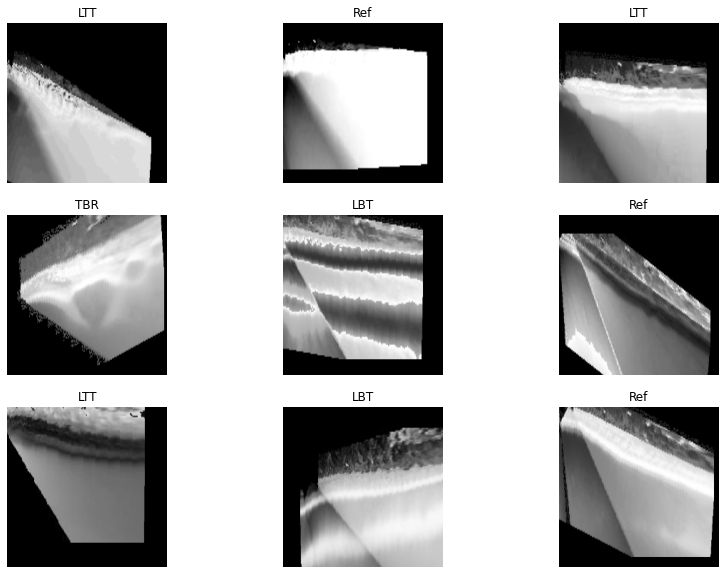

In [25]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label,_) = data[a]
        l = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(image_datasets['train'],inv_normalize)

#4. The Training and Validation Step
Finally, the last step is to setup the loss for the model, then run the training and validation function for the set number of epochs. Notice, depending on the number of epochs this step may take a while on a CPU. Also, the default learning rate is not optimal for all the models, so to achieve maximum accuracy it would be necessary to tune for each model separately.

The 'train_model' function handles the training and validation of a given model. As input, it takes a Pytorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model. 
The function trains for the specified number of epochs and after each epoch runs a full validation step. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model. After each epoch, the training and validation accuracies are printed.

In [26]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs, is_inception=False):
    since = time.time()

    #List to save out and watch learning convergence
    val_loss = []
    val_acc = []
    
    train_loss = []
    train_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    print(f'{num_epochs} epochs training...')
    for epoch in range(num_epochs):
        print('model: {}, Epoch: [{}/{}]'.format(model_name, epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, id in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device, dtype = torch.int64)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

                 
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            curr_lr = optimizer.param_groups[0]['lr']

            print('{} Loss: {:.4f} Acc: {:.4f} LR:{}'.format(phase, epoch_loss, epoch_acc, curr_lr))

            if phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                early_stopping(epoch_loss, model)
                # Note that step should be called after model.eval() <--> https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
                scheduler.step(epoch_loss)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
        if(early_stopping.early_stop):
            print("Early stopping")
            break
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:2f}'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)
    checkpoint = {'model_state': model.state_dict(),
              'model_name': model_name,
              'train_loss': train_loss,
              'val_loss': val_loss,
              'train_acc': train_acc,
              'val_acc': val_acc,
              'model': model}

    return checkpoint

### Model Training
Fine-tuning or feature extraction, depending on your choices before.

#### Run

In [27]:
run = 1

In [28]:
from torch.optim import lr_scheduler
import time
import copy
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.01, steps_per_epoch=len(dataloaders_dict['train']), epochs=10)
#Learning rate decay scheduler
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', factor=gamma, verbose=True, patience=8) 
# Train and evaluate
checkpoint_conv = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

1000 epochs training...
model: resnet50, Epoch: [1/1000]
----------
train Loss: 1.6490 Acc: 0.2500 LR:0.0003999999999999993
val Loss: 1.9356 Acc: 0.1176 LR:0.0003999999999999993
Validation loss decreased (inf --> 1.935567).  Saving model ...

model: resnet50, Epoch: [2/1000]
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.5468 Acc: 0.3254 LR:0.00043545290908663867
val Loss: 1.6074 Acc: 0.2647 LR:0.00043545290908663867
Validation loss decreased (1.935567 --> 1.607415).  Saving model ...

model: resnet50, Epoch: [3/1000]
----------
train Loss: 1.4370 Acc: 0.3879 LR:0.0004244600816168901
val Loss: 1.5616 Acc: 0.2059 LR:0.0004244600816168901
Validation loss decreased (1.607415 --> 1.561639).  Saving model ...

model: resnet50, Epoch: [4/1000]
----------
train Loss: 1.3666 Acc: 0.4375 LR:0.00042308785304504513
val Loss: 1.3787 Acc: 0.3235 LR:0.00042308785304504513
Validation loss decreased (1.561639 --> 1.378706).  Saving model ...

model: resnet50, Epoch: [5/1000]
----------
train Loss: 1.1745 Acc: 0.5588 LR:0.0004179987567832985
val Loss: 1.2627 Acc: 0.5147 LR:0.0004179987567832985
Validation loss decreased (1.378706 --> 1.262727).  Saving model ...

model: resnet50, Epoch: [6/1000]
----------
train Loss: 1.0711 Acc: 0.5864 LR:0.0004150994779364408
val Loss: 1.0221 Acc: 0.5882 LR:0.0004150994

In [29]:
# Save the trained model with model name and the run number
torch.save(checkpoint_conv, model_path + '/ft_{}_{}.pth'.format(model_name, run))

#### Visualize 
The Loss and the Early Stopping Checkpoint.
From the plot we can see the last Early Stopping Checkpoint

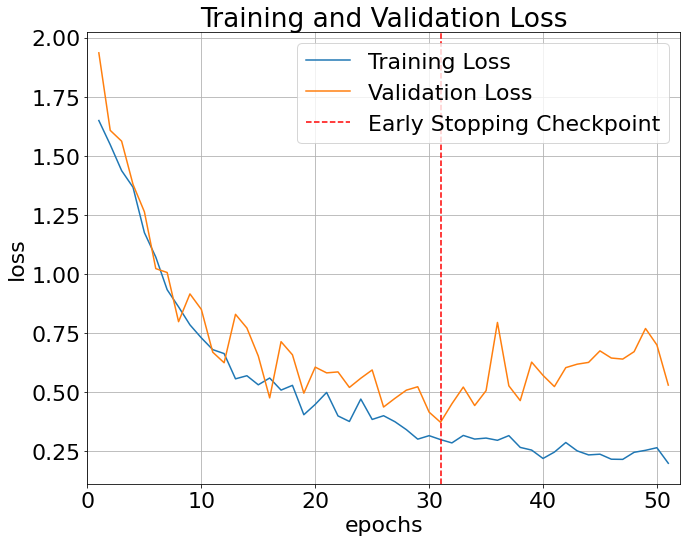

In [30]:
torch.cuda.empty_cache()
import torch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})
plt.plot(range(1,len(checkpoint_conv['train_loss'])+1),checkpoint_conv['train_loss'], label='Training Loss')
plt.plot(range(1,len(checkpoint_conv['val_loss'])+1),checkpoint_conv['val_loss'],label='Validation Loss')

# find position of lowest validation loss
minposs = checkpoint_conv['val_loss'].index(min(checkpoint_conv['val_loss']))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlim(0, len(checkpoint_conv['train_loss'])+1) # consistent scale
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

In [31]:
# Save the loss plot
fig.savefig(figures + 'loss_plot_ft_{}_{}.png'.format(model_name,run), bbox_inches='tight')

## Model Trained from Scratch
For visualization, lets see how the model learns if we do not use transfer learning. The performance of finetuning vs. feature extracting depends largely on the dataset but in general both transfer learning methods produce favorable results in terms of training time and overall accuracy versus a model trained from scratch.

### Run

In [32]:
patience = 20
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=learning_rate, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(scratch_optimizer, 'min', factor=gamma, verbose=True, patience=5) 
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.01, steps_per_epoch=len(dataloaders_dict['train']), epochs=10)
checkpoint_scratch = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, exp_lr_scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

1000 epochs training...
model: resnet50, Epoch: [1/1000]
----------
train Loss: 1.7809 Acc: 0.2721 LR:0.002
val Loss: 1.6748 Acc: 0.1176 LR:0.002
Validation loss decreased (inf --> 1.674838).  Saving model ...

model: resnet50, Epoch: [2/1000]
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

train Loss: 1.8009 Acc: 0.2224 LR:0.002
val Loss: 2.6310 Acc: 0.0735 LR:0.002
EarlyStopping counter: 1 out of 20

model: resnet50, Epoch: [3/1000]
----------
train Loss: 1.8634 Acc: 0.2592 LR:0.002
val Loss: 2.5597 Acc: 0.2206 LR:0.002
EarlyStopping counter: 2 out of 20

model: resnet50, Epoch: [4/1000]
----------
train Loss: 1.8126 Acc: 0.1985 LR:0.002
val Loss: 1.9549 Acc: 0.1176 LR:0.002
EarlyStopping counter: 3 out of 20

model: resnet50, Epoch: [5/1000]
----------
train Loss: 1.9851 Acc: 0.2482 LR:0.002
val Loss: 1.6545 Acc: 0.1471 LR:0.002
Validation loss decreased (1.674838 --> 1.654509).  Saving model ...

model: resnet50, Epoch: [6/1000]
----------
train Loss: 1.9400 Acc: 0.2169 LR:0.002
val Loss: 1.7730 Acc: 0.2794 LR:0.002
EarlyStopping counter: 1 out of 20

model: resnet50, Epoch: [7/1000]
----------
train Loss: 1.7589 Acc: 0.2482 LR:0.002
val Loss: 1.9644 Acc: 0.1471 LR:0.002
EarlyStopping counter: 2 out of 20

model: resnet50, Epoch: [8/1000]
----------
train Loss: 1.9139

In [33]:
# Save the trained model with model name and the run number
torch.save(checkpoint_scratch, model_path + '/scratch_{}_{}.pth'.format(model_name,run))

### Visualize 
The Loss and the Early Stopping Checkpoint.
From the plot we can see the last Early Stopping Checkpoint

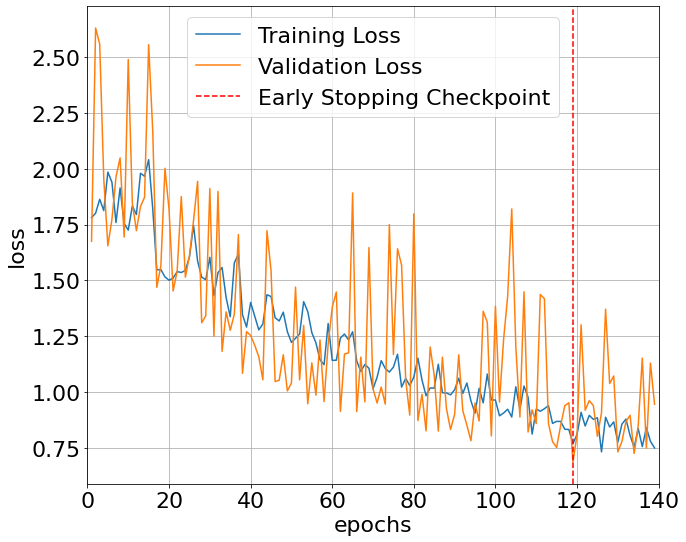

In [34]:
checkpoint = torch.load(model_path + '/scratch_{}_{}.pth'.format(model_name,run))

torch.cuda.empty_cache()
import torch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(checkpoint['train_loss'])+1),checkpoint['train_loss'], label='Training Loss')
plt.plot(range(1,len(checkpoint['val_loss'])+1),checkpoint['val_loss'],label='Validation Loss')

# find position of lowest validation loss
minposs = checkpoint['val_loss'].index(min(checkpoint['val_loss']))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlim(0, len(checkpoint['train_loss'])+1) # consistent scale
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Save the loss plot
fig.savefig(figures + 'loss_plot_scratch_{}_{}.png'.format(model_name,run), bbox_inches='tight')

## Transfer learning vs Scratch
The difference in validation accuracy for the pretrained model and the model trained from scratch.

In [36]:
checkpoint_ft = torch.load(model_path + '/ft_{}_{}.pth'.format(model_name,run))
checkpoint_scratch = torch.load(model_path + '/scratch_{}_{}.pth'.format(model_name,run))

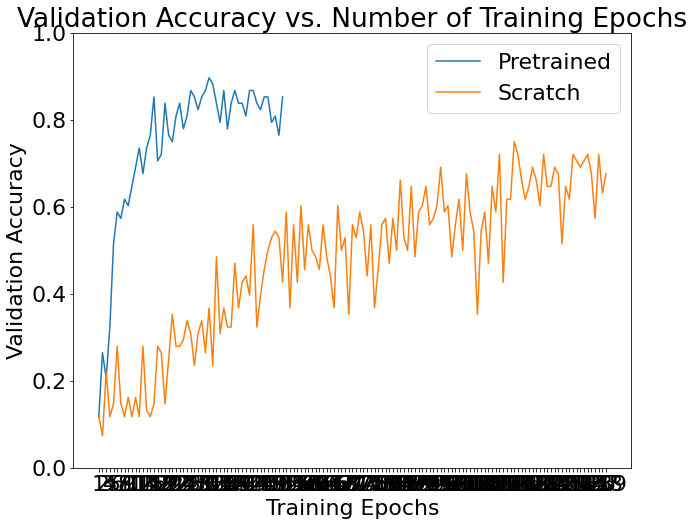

In [37]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in checkpoint_ft['val_acc']]
shist = [h.cpu().numpy() for h in checkpoint_scratch['val_acc']]
fig = plt.figure(figsize=(10,8))
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,len(ohist)+1),ohist,label="Pretrained")
plt.plot(range(1,len(shist)+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, len(shist)+1, 1.0))
plt.legend()

In [38]:
fig.savefig(figures + 'ft_vs_scratch_{}_{}.png'.format(model_name,run), bbox_inches='tight')

#6. Testing
Run the trained model on the *unseen* test data.

In [39]:
# Enter which run you want to use
run=1

In [40]:
checkpoint_ft = torch.load(model_path + '/ft_{}_{}.pth'.format(model_name,run))
model = checkpoint_ft['model']

In [41]:
CNN_preds = []
truth = []
id_list = []

total = 0 
correct = 0
with torch.no_grad():
    for inputs, labels, id in dataloaders_dict['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        
        truth += list(labels.cpu().numpy())
        CNN_preds += list(preds.cpu().numpy())

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        id_list += [ii for ii in id]

##Produce predictions for each site
CNN_results = {}
CNN_results.update({'ID':id_list, 'CNN':CNN_preds, 'truth':truth})

print('Accuracy of the network on the test dataset : %d %%' % (
    100 * correct / total))
#Save out

prediction_path = model_path + '/cnn_preds{}'.format(model_name)

Accuracy of the network on the test dataset : 79 %


In [42]:
# Save the predicitions with corresponding model name and the run number
torch.save(CNN_results, model_path + '/cnn_preds_{}_{}.pth'.format(model_name,run))

In [43]:
# To save the predictions to an .xlsx file
import pandas as pd
df = pd.DataFrame(CNN_results)
df.to_excel(data_dir + '/cnn_preds_{}_{}.xlsx'.format(model_name,run), index = False)

## Skill Evaluation
An important part in machine learning is the skill evaluation which will be done in several ways:
- Global skill, F1
- Precision
- Recall
- Accuracy 
- Normalized mutual info
- Confusion matrix

In [44]:
torch.cuda.empty_cache()
from sklearn import metrics
import matplotlib.pyplot as plt

predictions = torch.load(model_path + '/cnn_preds_{}_{}.pth'.format(model_name,run))
f1 = []
corrcoeff = []
nmi = []
recall = []
accuracy = []
precision = []

cnn_preds =  predictions['CNN']
true = predictions['truth']
precision.append(metrics.precision_score(true, cnn_preds, average='weighted'))
accuracy.append(metrics.accuracy_score(true, cnn_preds))
recall.append(metrics.recall_score(true, cnn_preds, average='weighted'))
f1.append(metrics.f1_score(true, cnn_preds, average='weighted'))
corrcoeff.append(metrics.matthews_corrcoef(true, cnn_preds))
nmi.append(metrics.normalized_mutual_info_score(true, cnn_preds))

report = metrics.classification_report(true, cnn_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

         Ref       0.71      1.00      0.83        10
         LTT       0.79      0.69      0.73        16
         TBR       0.76      0.87      0.81        15
         RBB       0.92      0.67      0.77        18
         LBT       0.80      0.89      0.84         9

    accuracy                           0.79        68
   macro avg       0.80      0.82      0.80        68
weighted avg       0.81      0.79      0.79        68



Text(0.5, 0, 'Predicted')

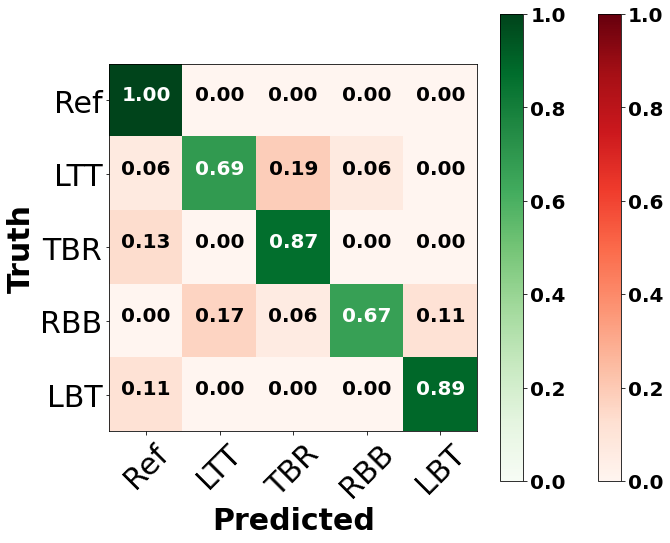

In [45]:
import itertools
from sklearn.metrics import confusion_matrix
normalize = True

conf_matrix = (metrics.confusion_matrix(true, cnn_preds))
off_diag_mask = np.eye(*conf_matrix.shape, dtype=bool)

vmin = np.min(conf_matrix)
vmax = np.max(conf_matrix)

np.set_printoptions(precision=1)
if normalize:
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_matrix_mask = np.ma.masked_where(off_diag_mask == False, conf_matrix)

cmap = 'Reds'
fig, axes = plt.subplots(figsize = (10,8),sharex = True, sharey = True, tight_layout = True)
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.weight"] = "bold"

plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.clim(0, 1)

i = plt.imshow(conf_matrix_mask, interpolation='nearest', cmap='Greens')
plt.colorbar()
plt.clim(0, 1)

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, fontsize=30)
plt.yticks(tick_marks, class_names, fontsize=30)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
        
axes.set_ylabel('Truth', fontsize = 30, weight = 'bold')
axes.set_xlabel('Predicted', fontsize = 30, weight = 'bold')

In [46]:
fig.savefig(figures + 'CM_ft_{}_{}.png'.format(model_name,run), bbox_inches='tight')

# 7. Model Visualisation
To visualise the models we used several methods following:
https://github.com/jacobgil/pytorch-grad-cam

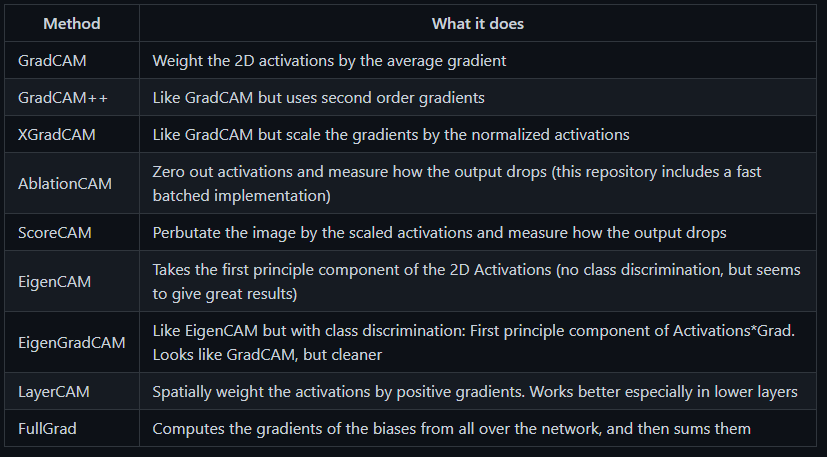

In [47]:
# Install the required code
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

method ="gradcam++"
model_name = 'resnet50'
run=1
model_path = '/content/drive/My Drive/DBS/Duck_publication/models'
checkpoint_ft = torch.load(model_path + '/ft_{}_{}.pth'.format(model_name,run),map_location=torch.device('cpu'))
model = checkpoint_ft['model']
imagename = 'Example_img.jpg'
image_path = f'/content/drive/My Drive/DBS/Duck_publication/CAM/{imagename}'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
    
target_layers = [model.layer4]

rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img1 = cv2.resize(rgb_img, (224,224))
rgb_img = np.float32(rgb_img1) / 255
input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])


    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
targets = None

    # Using the with statement ensures the context is freed, and you can
    # recreate different CAM objects in a loop.
cam_algorithm = methods[method]
with cam_algorithm(model=model,
                       target_layers=target_layers,
                       use_cuda=False) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=False,
                            eigen_smooth=False)

        # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

gb_model = GuidedBackpropReLUModel(model=model, use_cuda=False)
gb = gb_model(input_tensor, target_category=None)

cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)

cv2.imwrite(f'/content/drive/My Drive/DBS/Duck_publication/CAM/{method}_original_{imagename}_{run}.jpg', rgb_img1)
cv2.imwrite(f'/content/drive/My Drive/DBS/Duck_publication/CAM/{method}_cam_{imagename}_{run}.jpg', cam_image)
cv2.imwrite(f'/content/drive/My Drive/DBS/Duck_publication/CAM/{method}_gb_{imagename}_{run}.jpg', gb)
cv2.imwrite(f'/content/drive/My Drive/DBS/Duck_publication/CAM/{method}_cam_gb_{imagename}_{run}.jpg', cam_gb)

True